### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

## 0. Libraries installation

In [1]:
!pip install numpy pandas matplotlib scikit-learn tensorflow


  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.6/479.6 MB 95.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 144.7 MB/s eta 0:00:00
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached flatbuffers-24.3.25-py2.py3-none-any.whl (26 kB)
Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 156.1 MB/s eta 0:00:00
  

## 1. Load the images and extract the features

In [18]:
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [22]:
# Load the pre-trained model (VGG16)
model = VGG16(weights='imagenet', include_top=False, pooling='avg')

# Directory containing your images
image_dir = 'images_for_clustering/frechen'

# Function to load an image and preprocess it
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Extract features from all images
def extract_features(image_dir):
    features = []
    image_paths = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        
        # Skip directories and hidden files
        if os.path.isdir(img_path) or img_name.startswith('.'):
            continue
        
        img_array = load_and_preprocess_image(img_path)
        feature = model.predict(img_array)
        features.append(feature.flatten())
        image_paths.append(img_path)
        
    return np.array(features), image_paths


features, image_paths = extract_features(image_dir)

1/1 [==============================] - 0s 70ms/step


## 2. Apply clustering

In [30]:
# Apply K-Means clustering
num_clusters = 5  # You can change this based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(features)

# Get cluster labels
labels = kmeans.labels_

/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## 3. Visualize the clusters

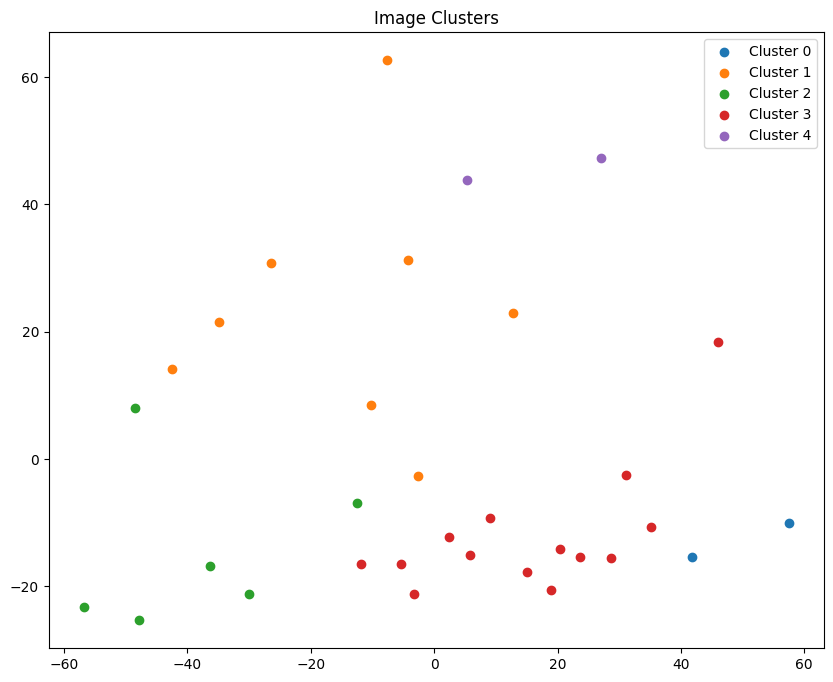

In [31]:
# Reduce dimensionality with PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    cluster_points = reduced_features[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
plt.legend()
plt.title('Image Clusters')
plt.show()


## 4: Review the Clustered Images

In [32]:
# Print image paths for each cluster
for i in range(num_clusters):
    print(f'Cluster {i}:')
    for img_path in np.array(image_paths)[labels == i]:
        print(img_path)
    print('\n')

Cluster 0:
images_for_clustering/frechen/Captura de pantalla 2024-08-28 142009.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 144525.png


Cluster 1:
images_for_clustering/frechen/Captura de pantalla 2024-08-28 144453.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 142101.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 144334.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 144427.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 144543.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 142136.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 144354.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 144445.png


Cluster 2:
images_for_clustering/frechen/Captura de pantalla 2024-08-28 142053.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 144511.png
images_for_clustering/frechen/Captura de pantalla 2024-08-28 141953.png
images_for_clustering/frech

In [33]:
import shutil

# Create the base directory for clustered images
cluster_base_dir = 'clustered_images/frenchen/'
os.makedirs(cluster_base_dir, exist_ok=True)

# Function to create directories for clusters and save images
def save_clustered_images(image_paths, labels, cluster_base_dir):
    for cluster_num in np.unique(labels):
        cluster_dir = os.path.join(cluster_base_dir, f'cluster{cluster_num + 1}')
        os.makedirs(cluster_dir, exist_ok=True)
        
        cluster_images = np.array(image_paths)[labels == cluster_num]
        for img_path in cluster_images:
            # Copy the image to the cluster directory
            shutil.copy(img_path, cluster_dir)

# Save the images in their respective cluster directories
save_clustered_images(image_paths, labels, cluster_base_dir)

print(f'Images have been saved in {cluster_base_dir} organized by clusters.')

Images have been saved in clustered_images/frenchen/ organized by clusters.


In [34]:
import shutil

# Path to the directory you want to zip
folder_to_zip = '/home/datascience/clustered_images/frenchen/'
zip_file_name = '/home/datascience/frenchen_clustered_images.zip'

# Create a zip file
shutil.make_archive(zip_file_name.replace('.zip', ''), 'zip', folder_to_zip)

print(f'Folder {folder_to_zip} has been zipped as {zip_file_name}.')

Folder /home/datascience/clustered_images/frenchen/ has been zipped as /home/datascience/frenchen_clustered_images.zip.


In [35]:
import IPython.display as ipd

# Provide a download link
ipd.FileLink('/home/datascience/frenchen_clustered_images.zip')

/home/datascience/frenchen_clustered_images.zip

## 5. Saving and reusing the clustering model

In [36]:
import joblib

# Save the K-Means model
joblib.dump(kmeans, 'kmeans_model.pkl')

# To load the model later
# kmeans = joblib.load('kmeans_model.pkl')

['kmeans_model.pkl']